# Transforming satellite data from one map projection to another

> history \| Create July 2023 \| Updated August 2023<br/>

## Background
Map projections try to portray the earth's spherical surface to the flat surface. A coordinate reference system (CRS) defines how the two-dimensional, projected map relates to real places on the earth. Which map projection and CRS to use depends on the regional in which you are working and the analysis you will do.

<a href="https://polarwatch.noaa.gov/" target="_blank">NOAA PolarWatch</a> distributes gridded and tabular oceanographic data for polar regions.  

Most of the satellite data in the PolarWatch data catalog use a projection based on a Geographic Coordinate Reference System, where the x and Y coordinates are longitude and latitude, respectively. Geographical coordinates work well in many parts of the globe, but within polar regions features tend to be very distorted. A Polar Stereographic projection often is a better choice for polar regions. For example, the NSIDC's Polar Stereographic Projections, which were developed to optimize mapping of sea ice, have only a 6% distortion of the grid at the poles and no distrortion at 70<sup>o</sup>, a latitude close to where the marginal ice zones occur. The <a href="https://polarwatch.noaa.gov/catalog/ice-sq-sh-nsidc-cdr-v4/preview/?dataset=daily&var=cdr_seaice_conc">NOAA NSIDC Sea Ice Concentration Climate Data Record</a> dataset, for example, is in a polar stereographic projection. 

When working with satellite datasets with a mix of map projections, it is often necessary to transform all the data to a common projection. 

## Objectives
In this exercise, we will learn to transform dataset coordinates of one projection to another.

## The exercise demonstrates the following techniques
-   Downloading and saving a netcdf file from PolarWatch ERDDAP data server
-   Accessing satellite data and metadata in polar stereographic projection 
-   Transforming coordinates using EPSG codes
-   Mapping data using the transformed coordinates

## Datasets used
__Sea Ice Concentration, NOAA/NSIDC Climate Data Record V4, Southern Hemisphere, Science Quality, 1978-2022, Monthly__   
The Sea ice concentration (SIC) dataset used in this exercise is produced by NOAA NSIDC from passive microwave sensors at part of the Climate Data Record. It is a science quality dataset of monthly averages the extends from 1978-2022. SIC is reported as the fraction (0 to 1) of each grid cell that is covered by ice. The data are mapped in the Southern Polar Stereographic projection (EPSG:3031). The resolution is 25km, meaning each grid in this data set represents a value that covers a 25km by 25km area. The dataset can be  downloaded directly from the PolarWatch ERDDAP at the following link: https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday


## Import  packages

In [11]:
import cartopy.crs as ccrs
import urllib.request
import pyproj
import xarray as xr
import numpy as np
from pyproj import CRS
from pyproj import Transformer
from matplotlib import pyplot as plt 
import cmocean

 ## Get data from ERDDAP

In [2]:
# request datafrom polarwatch.noaa.gov errdap and save it to sic.nc file

url = ''.join(["https://polarwatch.noaa.gov/erddap/griddap/",
               "nsidcG02202v4shmday.nc?cdr_seaice_conc_monthly",
               "[(2022-12-01T00:00:00Z):1:(2022-12-01T00:00:00Z)]", 
               "[(4350000.0):1:(-3950000.0)][(-3950000.0):1:(3950000.0)]"
               ])

urllib.request.urlretrieve(url, "sic.nc")

('sic.nc', <http.client.HTTPMessage at 0x1a80baf80>)

In [3]:
# open and assign data from the file to a variable ds using xarray
ds = xr.open_dataset("sic.nc")

In [4]:
# view metadata 
ds

<xarray.Dataset>
Dimensions:                  (time: 1, ygrid: 332, xgrid: 316)
Coordinates:
  * time                     (time) datetime64[ns] 2022-12-01
  * ygrid                    (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * xgrid                    (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    Conventions:                                         CF-1.6, ACDD-1.3, CO...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-12-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 2022-12-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

## Inspect CRS definitions and the transformation function

When transforming from one CRS to another, it is important to inspect CRS definitions and the transformation function for proper transformation.
We will transform from CRS EPSG: 3031 (NSIDC Polar Stereographic South) to EPSG: 4326 (geographic coordinate system)  . 

There are several ways to specify CRS as shown below.  For this exercise, we will use EPSG code.

```
1. crs = CRS.from_epsg(4326)
2. crs = CRS.from_string("EPSG:4326")
3. crs = CRS.from_proj4("+proj=latlon")
```

For this exercise, we will use method 1, the EPSG code.

### Get the projection information from the EPSG code
__Geographic__

In [5]:
crs_4326 = CRS.from_epsg(4326)
crs_4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

__NSIDC Polar Stereographic South__

In [7]:
crs_3031 = CRS.from_epsg(3031)
crs_3031

<Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Inspect CRS definitions

**crs_4326**
* order of axis: latitude first, and longitude in degree
* bounds (-180, -90, 180, 90) global coverage  

**crs_3031**
* order of axis: X then Y in meter 
* bounds (-180, -90, 180, -60)

**based on the crs definitions**
* transformation input should be in the order of latitude and longitude
* transformation input/output should be within the bounds


*NOTE: if you prefer to use lon and lat (or x, y) axis order, you can set transformer parameter **always_xy** to True*

```Transformer.from_crs(crs_3031, crs_4326, always_xy=True)```

## Transform the data

In [8]:
# transformer converts lon and lat values to x, y 
transformer = Transformer.from_crs(crs_3031, crs_4326)

# create a retangular grid 
x, y = np.meshgrid(ds.xgrid, ds.ygrid)

# pass x and y grid values to transform
lat, lon = transformer.transform(x,y)

## Add latitude and longitude values to the dataset

For adding the new coordinates to the dataset, create a tuple with its dimension and values then add to the dataset.  

- create a tuple  ```(dimension, value)```
- add to the dataset (ds) ```ds.coord['name']=(dimension, value)```


In [9]:
ds.coords['lat'] = (ds.cdr_seaice_conc_monthly[0][:].dims, lat)
ds.coords['lon'] = (ds.cdr_seaice_conc_monthly[0][:].dims, lon)

ds['cdr_seaice_conc_monthly'] = ds['cdr_seaice_conc_monthly'].where(ds['cdr_seaice_conc_monthly'] <= 1, np.nan)

## Plot data with new coordinates on a gloal map

Because the data were in the polar stereographic projection, mapping the data onto a different projection (global map projection) below, doesn't make the data fit well on the map.  


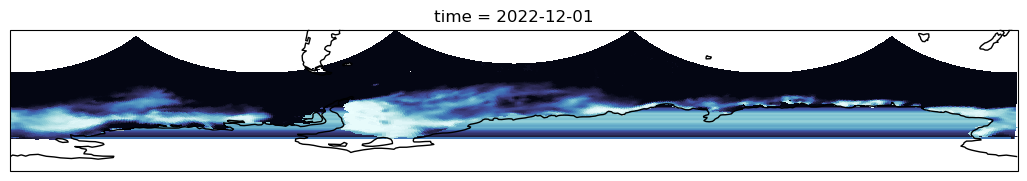

In [12]:
# set the map size
plt.figure(figsize=(13,5))

# set map projection (PlateCarree(): global map projection)
ax = plt.axes(projection=ccrs.PlateCarree())

# plot data with new coordinates
ds.cdr_seaice_conc_monthly[0][:].plot.pcolormesh('lon', 
                                                 'lat', 
                                                 ax=ax, 
                                                 transform=ccrs.PlateCarree(), 
                                                 cmap=cmocean.cm.ice, 
                                                 add_colorbar=False)
# add coastlines to the map
ax.coastlines()

## Plot data with new coordinates on a polar stereographic projected map

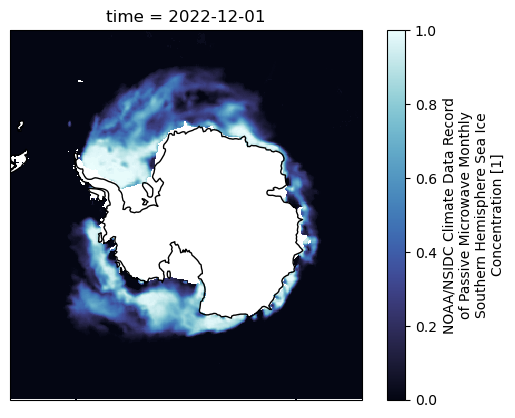

In [14]:
# set map projection (SouthPolarStereo(): southern polar stereographic projection)
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ds.cdr_seaice_conc_monthly[0][:].plot.pcolormesh('lon', 
                                                 'lat', 
                                                 ax=ax, 
                                                 cmap=cmocean.cm.ice, 
                                                 transform=ccrs.PlateCarree())

ax.coastlines()

## References
**Userful links**

-   <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=daily&var=cdr_seaice_conc&time_min=2022-05-31T00:00:00Z&time_max=2022-05-31T00:00:00Z&proj=epsg3413&colorBar=KT_ice|||0|1|" target="_blank">NOAA PolarWatch Data Product Page (download, preview)</a>
-   <a href="https://nsidc.org/data/g02202/versions/4" target="_blank">NSIDC Data Product Description</a>
-   <a href="https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf" target="_blank">NSIDC Data Product User Guide (pdf)</a>